# Advanced Machine Learning Project
Full Name: Imran Chowdhury Dipto <br> ID: 21420004

##Introduction
Auto Trader Group plc is the UK and Ireland's largest and most trusted digital automotive marketplace. For this project I have worked with their dataset which contains data such as price, make, model and so on. This project aims to analyse the dataset to engineer and select certain features from the dataset and train some Advanced Machine Learning (ML) to make price predictions and explain the model outputs so that the company can make an informed decision about adopting these algorithms to run their business. To reach this aim three advanced ML models namely; Random Forest Regressor, XGBoost Regressor and Linear Support Vector Regressor and an ensemble of the models called Bagged Regressor were built and trained on the dataset. Along with the usual data science libraries, patsy was used to encoding the categorical variables, split the features and the target and generate interactive features and SHAP was used to analyse the trained models. To evaluate the model predictions several evaluation methods have been used.

The results of this experiment show that age is one of the most impactful features which was engineered which was found from the Model Analysis phase. After building, fitting and training the models, Random Forrest Regressor was the ideal model having the lowest RMSE and MAE scores and had the highest R2-Scores compared to the other models. The remainder of the notebook is structured as follows; The rest of this section describes the Libraries and some of the custom functions used in this project, Data Handling and Inspection section describes the general information about the dataset along with descriptive statistics to understand the data. The methods used to clean the data has be presented in the Data Cleaning Section followed by the Feature Engineering and Selection Section. Then Preparation steps for training the ML models are presented in the Data Preparation Section Followed by an in-depth discussion of how the Models have been built and trained are elaborated in the Model Building, Fitting and Analysis Section. The Results Discussion section provides a comprehensive analysis of the results obtained from the trained models and finally, the Conclusion section provides a brief overview of the project with important lessons learned from the project with some suggestions for future work that could be done to improve the project.

###Libraries

The usual Libraries like Numpy, Pandas, Matplotlib and Seaborn have been used for data loading, analysis and visualisations. The Patsy library dmatrix object has been used to handle the predictor variables. The advantages of using dmatrix are that it helps in encoding categorical features into dummy variables and removes the last column to get rid of the last column to avoid multicollinearity. Also, it has been used to add an interaction term therefore an extra feature in the dataset used. For data processing, Machine Learning (ML) model training and evaluation the Sklearn has been used. Extra libraries are and warnings are used for implementing regular expression and warnings are used to ignore some warnings given after code execution. To understand the model interpretability, the SHAP package is installed which is used to identify the important features that impact most on the Model performances.

In [ ]:
#Importing important Libraries

# Libraries for loading and handling the data
import numpy as np
import pandas as pd
from patsy import dmatrix

#Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid") # Setting up whitegrid background for the graphs

# for missing value analysis
import missingno as msno

# to use regular expression
import re

# for splitting the data
from sklearn.model_selection import train_test_split
# for scaling the data
from sklearn.preprocessing import StandardScaler

# Importing the Model Objects
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor

# for evaluating the model performances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignoring some unecessary warnings to make the outputs more presentable
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Installing the SHAP package
!pip install -q shap
import shap
shap.initjs()

     |████████████████████████████████| 564 kB 10.9 MB/s 


### Helpter Functions
For this project, I have created some helper functions to display results. These functions help in code reusability as they are used repeatedly throughout the iterations. First I have written a custom function to generate a modified waterfall plot of shap to display the cumulative and composite ratio of the impact of the features on the model outputs. The other three functions display the true vs predicted prices, and their residual plots and final functions help in displaying evaluation metric scores on bar charts.

In [ ]:
# I am creating a custom function to display the true vs predicted prices of the regression models
def true_pred_plot(y_pred):
  g = sns.jointplot(x=y_test, y=y_pred, alpha=0.5)
  x0, x1 = g.ax_joint.get_xlim()
  y0, y1 = g.ax_joint.get_ylim()
  lims = [0, max(x1, y1)]
  g.ax_joint.set(xlim=lims, ylim=lims)
  g.ax_joint.plot(lims, lims, ':k', alpha=0.3, lw=1);
  g.ax_joint.set(xlabel='True Price Values')
  g.ax_joint.set(ylabel='Predicted Price Values');

In [ ]:
# A custom function to display the Residual Plots of the regression models
def resd_plot(y_pred):
  plt.figure(figsize=(5,5))
  residuals_df = y_pred - y_test
  sns.histplot(x = residuals_df, kde=True, stat='proportion', bins=30)

In [ ]:
# At the end of the notebook I will show the values of the matrices of the models with a help of a dataframe and draw some barplots to draw comparisons
# with the help of this function I will show the values at the top of the bars to make them more representable
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
# For the final representation of the outputs I will use these lists to store the results and plot them for Model Analysis
model_names = []
mae_test = []
rmse_test = []
r2_scores_test = []

## Data Loading and Inspection

In [ ]:
#I am importing drive to load the data stored in my personal space at Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# reading the CSV file and displaying the first 5 rows of the dataset
raw_df = pd.read_csv('drive/My Drive/Assessment/Advanced_ML/adverts.csv')
raw_df.head()

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


In [ ]:
# getting information about the dataset
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [ ]:
# descriptive statistics about the dataset
raw_df.describe(include='all')

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
count,4.020050e+05,401878.000000,370148,396627,402005,402005,402005,368694.000000,4.020050e+05,401168,402005,401404
unique,NaN,NaN,72,22,110,1168,2,NaN,NaN,16,2,9
top,NaN,NaN,17,Black,BMW,Golf,USED,NaN,NaN,Hatchback,False,Petrol
freq,NaN,NaN,36738,86287,37376,11583,370756,NaN,NaN,167315,400210,216929
mean,2.020071e+14,37743.595656,NaN,NaN,NaN,NaN,NaN,2015.006206,1.734197e+04,NaN,NaN,NaN
std,1.691662e+10,34831.724018,NaN,NaN,NaN,NaN,NaN,7.962667,4.643746e+04,NaN,NaN,NaN
min,2.013072e+14,0.000000,NaN,NaN,NaN,NaN,NaN,999.000000,1.200000e+02,NaN,NaN,NaN
25%,2.020090e+14,10481.000000,NaN,NaN,NaN,NaN,NaN,2013.000000,7.495000e+03,NaN,NaN,NaN
50%,2.020093e+14,28629.500000,NaN,NaN,NaN,NaN,NaN,2016.000000,1.260000e+04,NaN,NaN,NaN
75%,2.020102e+14,56875.750000,NaN,NaN,NaN,NaN,NaN,2018.000000,2.000000e+04,NaN,NaN,NaN


The dataset has a total of 12 columns with a record of more than 400k data points and many categorical, integer and float data types Only one column contains boolean type data.  As we are solving a regression problem, so the price of the cars is the target feature and the rest are dependent variables.

From the detailed statistical description of the dataset, we can see that there are a total of 110 different types of makes and 1168 different types of models of cars and most of them have "USED" conditions and are not crossovers. The BMW is the top makes in the dataset with Hatchback and Petrol being the top body type and fuel type of the cars. This description also shows the presence of outliers when the maximum, and minimum values are observed, so they will be dealt with later on in the project. 

For the simplicity of further analysis, I have then changed some of the column names. After the changes, we now have make, model, colour, reg_year, condition, crossover, mileage and public_reference as the features. I then looked further into the condition and crossover to see the total number of each of the categories in these columns. The condition of the car along with age can be a good indication of an interactive feature which is further described in the feature engineering phase.


## Data Cleaning

In [ ]:
# getting column names for inspection
raw_df.columns

Index(['public_reference', 'mileage', 'reg_code', 'standard_colour',
       'standard_make', 'standard_model', 'vehicle_condition',
       'year_of_registration', 'price', 'body_type', 'crossover_car_and_van',
       'fuel_type'],
      dtype='object')

In [ ]:
# renaming some column names to make analysis easier
raw_df.rename(columns = {'year_of_registration':'reg_year', 'crossover_car_and_van':'crossover', 
                         'standard_make':'make', 'standard_model':'model', 'body_type':'body',
                         'fuel_type':'fuel', 'standard_colour':'colour', 'vehicle_condition':'condition'}, inplace = True)
raw_df.columns

Index(['public_reference', 'mileage', 'reg_code', 'colour', 'make', 'model',
       'condition', 'reg_year', 'price', 'body', 'crossover', 'fuel'],
      dtype='object')

After loading the data I found in the first column that the vehicle with the new condition had no year of registration and reg code with a very low value of mileage. This makes sense as these cars are new so maybe their mileage for them to reach the showroom from the companies has been recorded. So it would be ideal to look at those vehicles more closely.

In [ ]:
# Inspecting the cars with "NEW" condition
new_cars_df = raw_df[raw_df['condition']=='NEW']
new_cars_df

,public_reference,mileage,reg_code,colour,make,model,condition,reg_year,price,body_type,crossover,fuel_type
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
17,201911043995897,5.0,NaN,NaN,Nissan,X-Trail,NEW,NaN,27595,SUV,False,Diesel
19,202008272998331,0.0,NaN,White,Volkswagen,T-Cross,NEW,NaN,25000,SUV,False,Petrol
37,202001306737473,0.0,NaN,White,Fiat,Panda,NEW,NaN,13999,Hatchback,False,Petrol
44,202003178531910,0.0,NaN,NaN,Honda,Civic,NEW,NaN,19495,Hatchback,False,Petrol
...,...,...,...,...,...,...,...,...,...,...,...,...
401860,202010024501227,10.0,NaN,Silver,Mitsubishi,Shogun Sport,NEW,NaN,31999,SUV,False,Diesel
401890,202010104843364,5.0,NaN,Red,BMW,Z4,NEW,NaN,47910,Convertible,False,Petrol
401902,202010134960554,10.0,NaN,White,BMW,3 Series,NEW,NaN,35023,Saloon,False,Petrol
401905,202010144983518,0.0,NaN,Red,Land Rover,Range Rover Evoque,NEW,NaN,44995,SUV,False,Petrol


In [ ]:
# checking missing values of their reg_codes
new_cars_df['reg_code'].isna().sum()

31249

In [ ]:
# checking missing values of the reg_year
new_cars_df['reg_year'].isna().sum()

31249

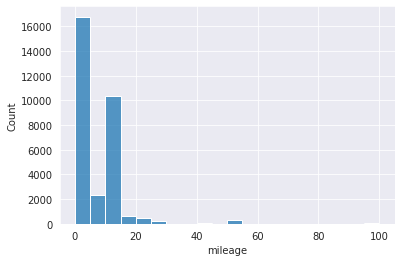

In [ ]:
# looking at the new cars mileage distribution
sns.histplot(x=new_cars_df['mileage'],data=new_cars_df,bins=20)

From the data inspection stage and this analysis, we can identify a pattern in the dataset. It was found that the new car count is 31249. After further inspection of these new cars, we can see that they have missing values of reg_code and reg_year and the number of missing values is also 31249. Also, from the histogram of the mileage, we can see that most of these cars have a mileage range of 0 to 10 so we can assume that this mileage was covered by driving them into the shop after production or test drives. As they are all new cars so it can be further assumed that they can be assigned the registration year of 2022 which is needed to extract an important additional feature from this dataset.

In [ ]:
# changing the crossover column to object type as it has boolean values True and False which means Treu = 1 and False = 0 so that this feature is recodnised as categorical
raw_df['crossover'] = raw_df['crossover'].astype('object')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   public_reference  402005 non-null  int64  
 1   mileage           401878 non-null  float64
 2   reg_code          370148 non-null  object 
 3   colour            396627 non-null  object 
 4   make              402005 non-null  object 
 5   model             402005 non-null  object 
 6   condition         402005 non-null  object 
 7   reg_year          368694 non-null  float64
 8   price             402005 non-null  int64  
 9   body              401168 non-null  object 
 10  crossover         402005 non-null  object 
 11  fuel              401404 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 36.8+ MB


### Identification and Handling of Missing Values

ML Models need cleaned data without any missing values, in this step I have identified the number of missing values in columns in the dataset and also showed the proportion of them by drawing a bar plot.

In [ ]:
# Dealing Missing values
raw_df.isnull().sum()

public_reference        0
mileage               127
reg_code            31857
colour               5378
make                    0
model                   0
condition               0
reg_year            33311
price                   0
body_type             837
crossover               0
fuel_type             601
dtype: int64

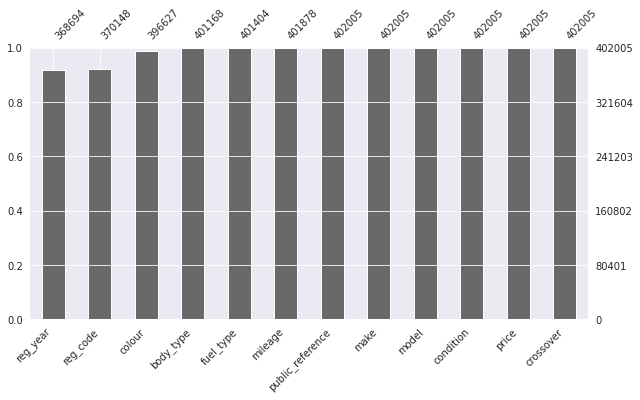

In [ ]:
# graph to show the proportion of missing values in the dataset
msno.bar(raw_df, sort='ascending',fontsize=10,figsize=(10,5)) 

From the results, we can see that the reg_year and reg_code have the highest proportion of missing values in the entire dataset. Among other columns, mileage, body_type and fuel_type also have some missing values. To deal with these missing values, I have filled the reg_year with 2022 as they are new and unregistered cars. I have filled in the missing values of mileage with the median value. For the imputation of categorical variables I have taken the most frequent category and filled the missing column with that category. I have opted to use these methods because the observations in the mileage column are highly skewed as seen from the data description and will be further shown in the outlier detection phase, so using the median value will help in retaining the representability of data and the same can also be said about the selection of the most frequent category to fill in the missing values of the categorical columns. I did not change or fix the reg_code and colour columns and will remove them in the feature selection stage.

In [ ]:
# filling missing values of reg_year by adding 2022 to unregistered cars
# filling missing values of mileage by taking adding the median of the column

raw_df['reg_year'] = raw_df['reg_year'].fillna(2022.0)
raw_df['mileage'] = raw_df['mileage'].fillna(raw_df['mileage'].median()) 

In [ ]:
# I am writing a function to replace the missing categorical values with the most frequent category i.e mode
# so if we have the highest number of black cars in the dataset then they will be replaced with blue

def impute_nan_most_frequent_category(DataFrame,ColName):
     most_frequent_category=DataFrame[ColName].mode()[0]
    
    # I am replacing NaN values with most occured category by using fillna method
     DataFrame[ColName] = DataFrame[ColName]
     DataFrame[ColName].fillna(most_frequent_category,inplace=True)

# Calling the function to impute most occured category
for Columns in ['body','fuel', 'colour']:
    impute_nan_most_frequent_category(raw_df,Columns)

In [ ]:
# checking for missing values again to make sure
raw_df.isnull().sum()

public_reference        0
mileage                 0
reg_code            31857
colour                  0
make                    0
model                   0
condition               0
reg_year                0
price                   0
body                    0
crossover               0
fuel                    0
dtype: int64

## Feature Engineering and Selection
Feature Engineering is the process of deriving new features in several ways depending on domain knowledge or from the extraction of new features from the given features from the dataset by performing certain calculations, transformations and so on. This step is important because our model's prediction capabilities could heavily rely on these new features. From the analysis done so far on this dataset, we can see that reg_year is giving us a hint at identifying a new feature. By subtracting the current year (2022) from these years we can get the ages of the vehicles and add this as a new feature to our dataset. On our dataset, we have both make and model names of the cars so it would be interesting to combine both of them to create another feature and these tasks have been performed in the following code cell.

In [ ]:
# Adding new features based on domain knowledge first I will add age then make a new feature called make_model 
# by combining make and model. To get the age I will substract current year from the given years.
raw_df['age'] = 2022 - raw_df['reg_year']
raw_df['make_model'] = raw_df['make'] + '_' + raw_df['model']
raw_df.head()

,public_reference,mileage,reg_code,colour,make,model,condition,reg_year,price,body,crossover,fuel,age,make_model
0,202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,2022.0,73970,SUV,False,Petrol Plug-in Hybrid,0.0,Volvo_XC90
1,202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel,11.0,Jaguar_XF
2,202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol,5.0,SKODA_Yeti
3,202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel,6.0,Vauxhall_Mokka
4,202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel,7.0,Land Rover_Range Rover Sport


After the creation of the age feature, it is important to check its statistical significance to see whether it would add any value in training the models using this feature. To see this I have plotted a correlation plot showing the Pearson's correlation coefficients against all the numeric features in the dataset. This will not only help us to identify the importance of the age feature with price but will also help us decide on whether to keep this feature and how it correlates to other numeric features. 

One of the tasks of this project is to create interactive features, to do so I will also create some new features which are age+mileage, age times the mileage and polynomial features such as the squares of age and mileage. The correlation of these features will help me understand their relationships and will allow me to keep one such feature in the dataset.

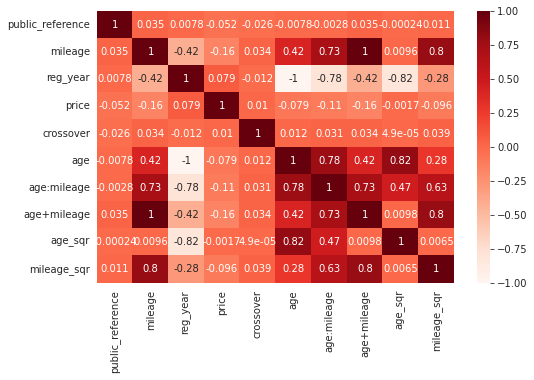

In [ ]:
# I will generate a correlation coefficient plot to understand the relationships betweeen numeric
# in addition I will also create some interactive features from which I will add to the dataset later
test_df = raw_df
test_df['age:mileage'] = test_df['age'] * test_df['mileage']
test_df['age+mileage'] = test_df['age'] + test_df['mileage']
test_df['age_sqr'] = test_df['age'] ** 2
test_df['mileage_sqr'] = test_df['mileage'] ** 2

plt.figure(figsize=(8,5))
cor = test_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

For the plot above we can see that age is positively correlated with price and the opposite is seen for reg_year having the same correlation coefficient, this means that newer cars will be more expensive compared to the old ones. From this observation, we can conclude that having both reg_year and age for training the models is not feasible so I will drop the reg_year column when selecting the features. Furthermore, the reg_code of the cars also provides us with the age of the car so since we have already calculated the age of the cars I will remove the reg_code. Since I have already joined the makes with models so it doesn't make any sense to keep the make and model as separate features.

From the created features, it seems that age times the mileage has a strong negative correlation with price and perfectly makes sense because as age and mileage increase the price of the cars will fall as the cars become older, so for training the models this interactive feature could be very important, so I will keep this feature for building, fitting and training the ML Models.

In [ ]:
# selection of features based on the graph and domain knowledge
raw_df = raw_df.drop(columns=['reg_code','public_reference','reg_year','make','model'])
raw_df.head()

,mileage,colour,condition,price,body,crossover,fuel,age,make_model
0,0.0,Grey,NEW,73970,SUV,False,Petrol Plug-in Hybrid,0.0,Volvo_XC90
1,108230.0,Blue,USED,7000,Saloon,False,Diesel,11.0,Jaguar_XF
2,7800.0,Grey,USED,14000,SUV,False,Petrol,5.0,SKODA_Yeti
3,45000.0,Brown,USED,7995,Hatchback,False,Diesel,6.0,Vauxhall_Mokka
4,64000.0,Grey,USED,26995,SUV,False,Diesel,7.0,Land Rover_Range Rover Sport


### Outlier Detection and Handling
Outliers are considered extreme values that lie outside a given range of numeric values. The presence of such values can have a profound impact on the performance of ML models, especially regression models. In this stage, I will investigate the numeric features on the dataset to identify these values. To identify these values I will draw the boxplots and histograms of the price, age and mileage.

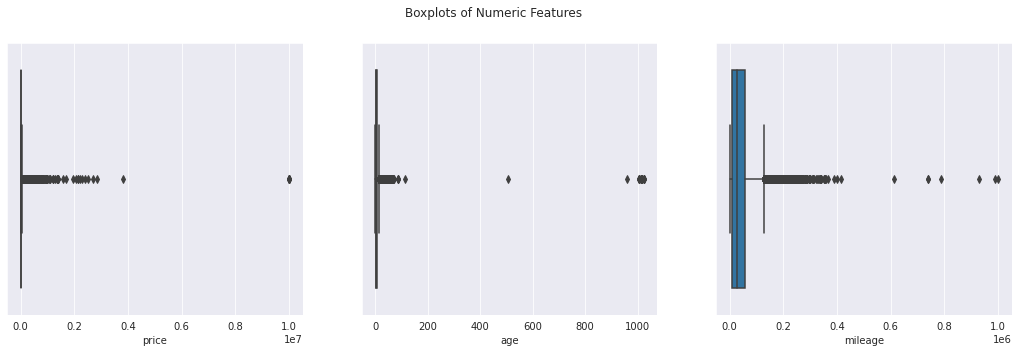

In [ ]:
# To show that I have gotten rid of all the outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Boxplots of Numeric Features')

sns.boxplot(ax=axes[0], x='price',data=raw_df)
sns.boxplot(ax=axes[1], x='age', data=raw_df)
sns.boxplot(ax=axes[2], x='mileage', data=raw_df)

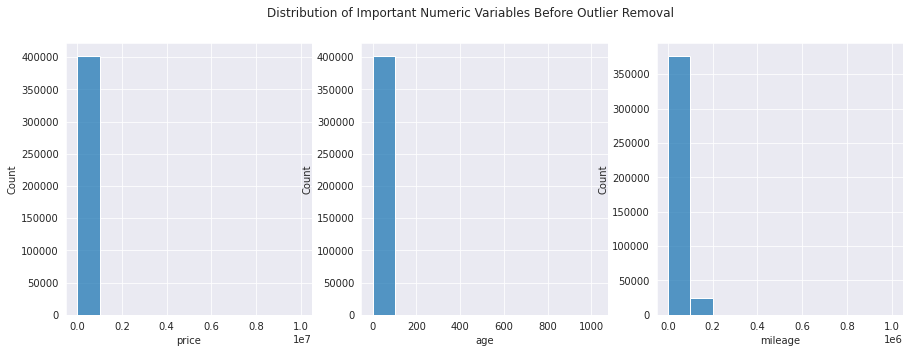

In [ ]:
# To show that I have gotten rid of all the outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribution of Important Numeric Variables Before Outlier Removal')

sns.histplot(ax=axes[0], x='price',data=raw_df,bins=10)
sns.histplot(ax=axes[1], x='age', data=raw_df,bins=10)
sns.histplot(ax=axes[2], x='mileage', data=raw_df,bins=10)

From the boxplots, we see that all the numeric features have some unrealistic values in the dataset. For instance, if we look closely at age there are cars between the ages of 600 to 1000, and there are prices of 0.2 times 10^7 to 10^7 whereas the average age of any cars on the roads in the UK is about 8.5 years and the price range is between 12K to 28K depending on the car brands and types. We can see similar observations for the mileage as well. From the histograms, we can see that all the distributions are left-skewed and if we feed this data to our models we will have a hard time making proper predictions. To solve these issues I will drop the outliers by finding the interquartile range of these features and then drop values which do not fall in this range. This way I will not only get rid of the outliers but will also fix the skewness of the data distribution.

In [ ]:
#Dealing with outliers
Q1 = raw_df.quantile(0.25)
Q3 = raw_df.quantile(0.75)
IQR = Q3 - Q1

# This is done for the Multilinear Regression model to show the interactions
raw_df = raw_df[~((raw_df < (Q1 - 1.5 * IQR)) |(raw_df > (Q3 + 1.5 * IQR))).any(axis=1)] 

raw_df.shape

(354301, 9)

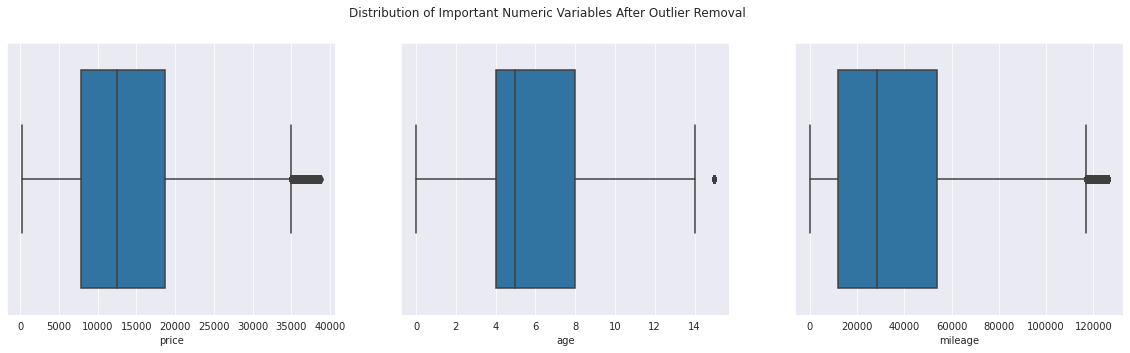

In [ ]:
# To show that I have gotten rid of all the outliers
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distribution of Important Numeric Variables After Outlier Removal')

sns.boxplot(ax=axes[0], x='price',data=raw_df)
sns.boxplot(ax=axes[1], x='age', data=raw_df)
sns.boxplot(ax=axes[2], x='mileage', data=raw_df)

In [ ]:
raw_df['condition'].value_counts()

USED    331355
NEW      22946
Name: condition, dtype: int64

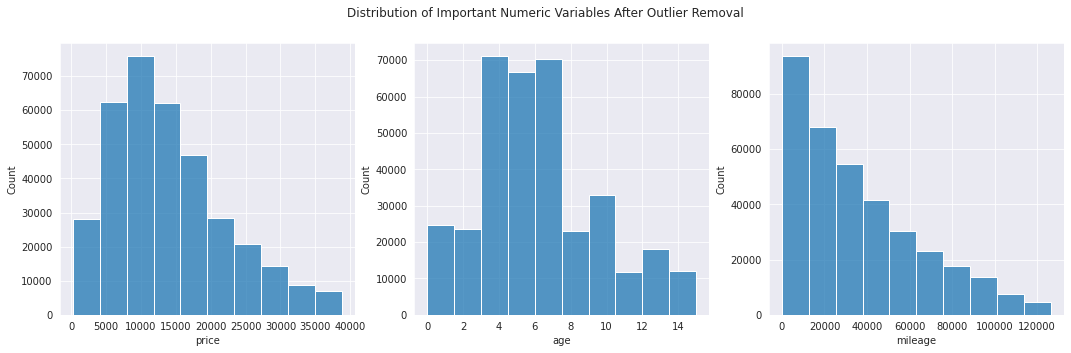

In [ ]:
# To show that I have gotten rid of all the outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Important Numeric Variables After Outlier Removal')

sns.histplot(ax=axes[0], x='price',data=raw_df,bins=10)
sns.histplot(ax=axes[1], x='age', data=raw_df,bins=10)
sns.histplot(ax=axes[2], x='mileage', data=raw_df,bins=10)

After getting rid of the outliers I have generated the plots of the new data. From the boxplots, we can see that our data looks much cleaner and more realistic for training ML models. From the boxplots we can interpret that we still have some extreme values, however, I will not delete them as it would then result in the loss of representability of the data for the models. Improvement in the skewness is also observed as the distribution of the data is almost normal for price and age but it is a bit left-skewed for the mileage after the removal of the outliers it is now possible to use this data for training the models.

## Data Preparation
In this further features will be added to the dataset to properly train the model. In this stage, I will encode the categorical features, add an extra feature selected based on interaction, separate the data into predictors and target variables, split the data into training and test sets and scale them for model training.

### Handling Categorical Data
ML models are unable to interpret categorical data and they can only understand numbers. For instance, if we feed the condition column with strings "USED" and "NEW" then the models will not be able to fit the data. To overcome this situation I will encode the categorical data to 0s and 1s and this process is known as One-Hot Encoding. For instance, from the condition column, we can derive two features like condition_used having values 0 and 1 where 0 means that the car is used and 1 means new. For adding an interaction between two features I will multiply age with the encoded condition. To handle this tedious task I will use the dmatrix object of the patsy library which will make this task quite convenient for us as it will get rid of any extra dummy variables and allow us to easily add an interacted feature. To add the interactive feature I will combine age and mileage and see how this feature impacts the ML Models.

In [ ]:
# Using Patsy to encode the data and create feature inetractions
from patsy import dmatrices
formula = 'price ~ age + mileage + body + fuel + condition + crossover + colour + make_model + age:mileage - 1'
y, X = dmatrices(formula, raw_df, return_type='dataframe')

# displaying the first 5 columns of the independent features stored in X
X.head()

,body[Camper],body[Car Derived Van],body[Chassis Cab],body[Combi Van],body[Convertible],body[Coupe],body[Estate],body[Hatchback],body[Limousine],body[MPV],...,make_model[T.Volvo_XC60],make_model[T.Volvo_XC70],make_model[T.Volvo_XC90],make_model[T.Westfield_1600],make_model[T.Westfield_Roadster],make_model[T.Westfield_Se],make_model[T.Zenos_E10],age,mileage,age:mileage
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,108230.0,1190530.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,7800.0,39000.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,45000.0,270000.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,64000.0,448000.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,16000.0,80000.0


In [ ]:
# displaying the first five target (y)
y.head()

,price
1,7000.0
2,14000.0
3,7995.0
4,26995.0
5,29000.0


###Seperating the Data into Predictors and Target Variables
The next step is to separate the target and the predictor variables. In this stage, I have dropped the price from the cleaned data and took it as the X variable and put only our target "price" in the y variable. One downside I found in patsy is that it adds some special characters to column names while encoding so to fix it I have used a regular expression.

In [ ]:
# Throughout this experiment I found that patsy encodes the names in such a way that it leaves some characters on categorical features
# it like '[ ] <' so these
# special character labels are not supported by the XGBoost so I am writing a regular expression to get rid of them so that I can display the
# dependence plots using SHAP.

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[',']','<'))) else col for col in X.columns.values]

print(X.shape, y.shape)

(354301, 826) (354301, 1)


###Splitting the Features and Target into Training and Test Samples
In this part, I have split the X and y into training and test sets. I have taken the test size to be 20% of the entire dataset leaving 80% for training. This split is a common practice in the ML community. I have set the random_state parameter to be 42 to get reproducibility 

In [ ]:
# Seperating the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(283440, 826) (70861, 826) (283440, 1) (70861, 1)


In [ ]:
# as I will be testing the models on the test set, we saw that the y variables is a 2D dataframe and parts of this data will be used to train the models
# but the predictions made by the models will be in 1D, as I will plot treu vs predicted plots and residual plots against the true values stored in y_test
# so I will get a shape missmatch error while generating these plots so I need to convert the shape of the y_test to 1D array.
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1)
y_test

array([22069., 13499.,  3975., ..., 36142.,  4595.,  4990.])

### Scaling the Data
For this project, I will be implementing the Random Forest, XGBoost, Linear SVR and a Bagged regression. Although tree-based models can interpret unscaled data, to train non-tree based models like SVR and Bagged Regressor we have to scale our data so that they can interpret the data well. The standard scaler is used which normalises the data and puts it in the range of -1 to 1 by calculating the Z-Scores of each of the values in the feature columns. This method is also widely used in the ML community.

In [ ]:
# Scaling the data stored into X, X_train and X_test
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

## Model Building, Tuning, Fitting and Analysis
For this project, three different types of advanced ML models namely; Random Forrest (RF) Regressor, XGBoost (XGB) Regressor and Linear Support Vector Regressor (SVR) and a Bagged Ensamble of the three models used which will be discussed further in the following sections. The experiments have been carried out several times to identify the ideal hyperparameters to generate the best results. To evaluate the model performances three evaluation metrics have been used. Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and R2 Squared.

###Evaluation Metrics

<li><b>MAE:</b> 
It is the error of the true prices - predicted prices. MAE take the average of this error from the entire dataset and gives the output. To get an understanding of the mode's performances for this project MAE is a good measure, but MAE is not very sensitive to outliers, it gives a linear value by averaging the wight of the individual predictions equally. The lower the value the better is the model's performance.</li>
<li><b>RMSE:</b> Means Squared Error is the average of the squared difference between the actual and the predicted outcomes and the RMSE is the root of this value. RMSE is useful for this task because the errors are squared before they are averaged, this means that RMSE applies higher weight to larger errors. This means that for this dataset RMSE is much more useful as we have large errors present and they drastically affect the model's performance. In this metric also, the lower the value, the better the performance of the model. Another advantage is the error value will be the same as the car prices which will make model analysis much convenient.</li>
<li><b>R2-Score:</b> Also referred to as the coefficient of determination, this metric will tell us how good our models have fitted the AutoTrader dataset as it identifies how close the regression line is to the predicted prices. The R squared value lies between 0 and 1 where 1 indicates that the model has perfectly fitted the dataset.</li>

Throughout the notebook, I have provided the calculated results of the MAE, RMSE and R2-Scores of the models and visualised the outputs of the model's True Vs Predicted plots and residual plots haven generated for each of the models to provide a visual understanding of the model's performance on the test data.

####Model Explanation 
\To explain the three trained models (RF, XGB and SVR), I have used SHAP. This library helps us debug the models to gain insight into the most important features of the dataset which had the most impact on the model's outcome. This step is crucial for AutoTrader as from such outputs the stakeholders of the company can understand and identify these important features, check whether they align with the business objectives and finally can these model(s) be put into production.

Shapley Additive exPlanations or SHAP in short uses the concepts of game theory to explain model predictions. Starting with some base values for predictions based on prior knowledge, then it tires the features of the data one by one to comprehend the impact of the interactions of that feature on the base value to reach the final prediction. Moreover, it considers orders of features introduced to the models along with the interactions between them which helps us better understand the model performance. During this stage, it records shap values which will be then used to generate several plots to explain our models. <br>

SHAP library has several classes which we can use to interpret different types of ML models. These classes are called explainers which usually take in the fitted ML models and data returning SHAP values which I have used to plot different visuals. Since I have implemented two tree-based and one linear model so I have used the TreeExplainer and LinearExplainer objects to get the SHAP values. Then I plotted Summary Plots, Waterfall Plots of 20 features and Force Plots, and Dependence Plots of the top 4 features of the three models. I have limited the number of features to 20 as we saw from the introduction of new features from categorical encoding we get a massive feature explosion so showing all of them will not make the diagrams meaningful. Since bagged models are not yet supported by SHAP explainers it is not yet possible to draw these plots of the model outputs of the Bagged Regressor Model.

Following are the descriptions of the plots I have used to explain the model's behaviours.

<li><b>Summary Plot:</b> This plot shows a combination of feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature. The features are ranked in terms of importance which are shown on the y-axis along with the Shapley values on the x-axis where colours represent the value of the feature from low to high. Overlapping points are jittered in the y-axis direction, so it provides a sense of the distribution of the Shapley values per feature. This plot shows us first instances of the indications of the relationship between the value of a feature and the impact on the prediction. But to see the exact form of the relationship, I have also included SHAP dependence plots.</li>

<li><b>Dependence Plot:</b> It is a scatter plot which shows us the effect of a single feature on the predictions made by the trained models. Dots represent a single prediction (row) of the dataset, the x-axis is the actual value, and the y-axis is the SHAP value for that feature, showing how much knowing that feature value changes the output of the model for that prediction. The colour denotes a 2nd feature that may have an interaction effect with the feature we are plotting and this feature is chosen automatically by SHAP. If we are plotting it will show up as a distinct vertical pattern of colouring. </li>

<li><b>Force Plot:</b> This plot shows the explainability of a model's predictions. This plot is used for error analysis and finding the explanation for specific instance prediction. This plot provides a base value f(x) which is the prediction (price) of the cars that would be known as the base value that would be predicted if we did not know any features for the current instance, this value is the average of the model output over the test dataset (explainer.expected_value) as written in the code. In the plot, Red shows features that push the model score higher, and blue represents features that push the score lower. The bigger the arrow, the bigger the impact of the feature on the output and the amount of decrease or increase in the impact can be seen on the x-axis.</li>







###Random Forest
The Random Forest Regressor is a type of Supervised Algorithm which can solve both classification and regression tasks. It takes several regression decision trees and makes them 'vote'. Each tree predicts the expected price of a car based on the decision criteria it picked up during training. This algorithm then calculates an average of all of the predictions to generate an estimate of what the expected price of a car should be. During several iterations in this project, I found a number of hyperparameters to be useful for generating the ideal results after training and making predictions using the Random Forest Regressor. As this Algorithm works by building several decision trees, for this project 15 trees are found to be optimal, criteria is another hyperparameter which is a function that measures the quality of the splits of the trees and "squared_error" is used which is for the mean squared error which tackles our given problem and is runs faster compared to other functions.

In [ ]:
# calling the RandomForestRegressor Object with optimal hyperparameters
rf = RandomForestRegressor(n_estimators=15, criterion="squared_error",n_jobs=-1)

# fitting the model
rf.fit(X_train_sc, y_train)

# making predictions
y_pred_rf = rf.predict(X_test_sc)

In [ ]:
# storing the evaluated values
rf_mae_test = np.round(mean_absolute_error(y_test, y_pred_rf),2)
rf_rmse_test = np.round(mean_squared_error(y_test, y_pred_rf,squared=False),2)
rf_r2_test = np.round(r2_score(y_test, y_pred_rf),2)

# printing the results
print("MAE of Random Forest Regressor on the Test Set: ", rf_mae_test)
print("RMSE of Random Forest on the Test Set: ", rf_rmse_test)
print("R2 score of Random Forest is: ",rf_r2_test)

# appending the results into the lists
model_names.append("Random Forest Regressor")
mae_test.append(rf_mae_test) 
rmse_test.append(rf_rmse_test)
r2_scores_test.append(rf_r2_test)

MAE of Random Forest Regressor on the Test Set:  1517.02
RMSE of Random Forest on the Test Set:  2281.19
R2 score of Random Forest is:  0.92


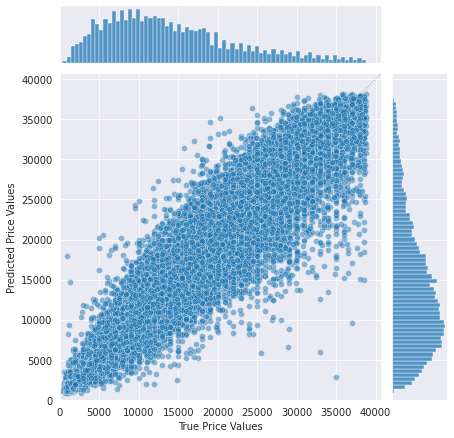

In [ ]:
# Calling the function to get the true vs predicted plot on the test set
true_pred_plot(y_pred_rf)

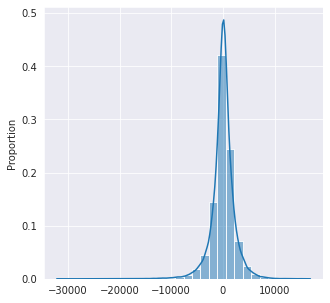

In [ ]:
# getting the residual plot
resd_plot(y_pred_rf)

The MAE and RMSE scores of the Random Forest Regressor are very low with an R2 Score of 0.92. The RMSE score is 2281.19 this means that the model is just off by this value in making predictions of the car prices. The high score of R2 also indicates that this model has fitted the data quite well in making predictions and this is reflected on the residual plot.

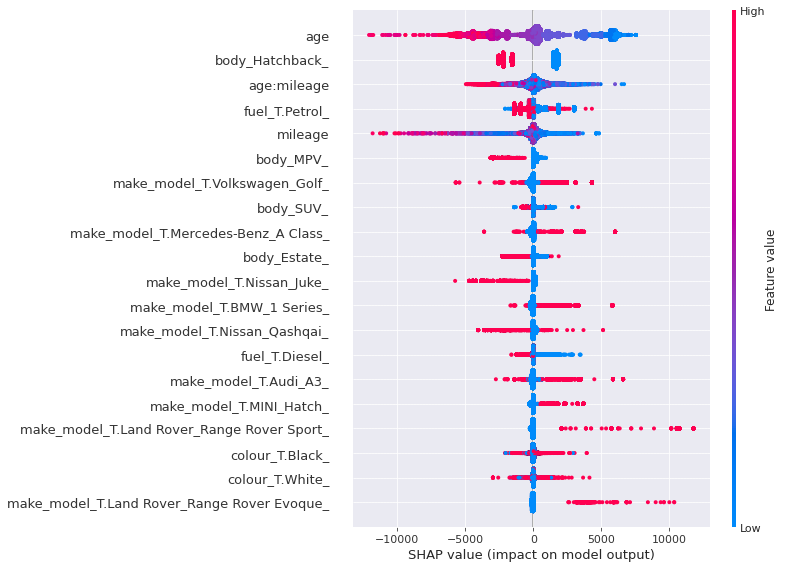

In [ ]:
# generating shap global explanation of mean absolute SHAP values as feature importance of Random Forrest Regressor
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_sc, tree_limit=10, approximate=True, check_additivity=False)
shap.summary_plot(shap_values, X_test)

After training Random Forrest Regressor and generating the SHAP Summary plot, we can see that `age` is the most important feature, as it has a high shaply value range. From the summary plot, we can see that the four most important features of the Random Forrest Regressor is `age`, `body_Hatchback_`, `age:mileage` and `fuel_T.Petrol_`. So to understand the further relationships.

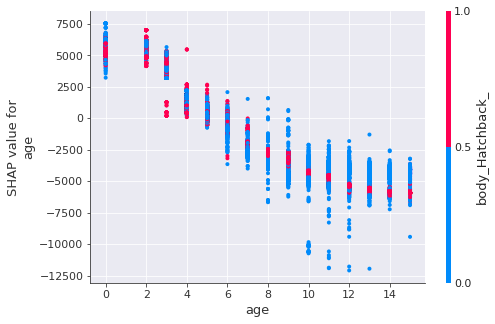

In [ ]:
# Drawing dependence plots of the important features
shap.dependence_plot('age', shap_values, X_test, interaction_index='body_Hatchback_')

From the dependence plot of age, we can see that cars between the ages  0 to 4 having a body type of hatchback has the most impact on the model performance.

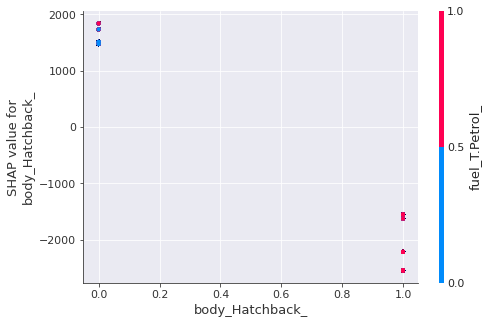

In [ ]:
shap.dependence_plot('body_Hatchback_', shap_values, X_test, interaction_index='fuel_T.Petrol_')

This plot shows that when cars that are not Hatchbacks and do not use petrol impacts the model most.

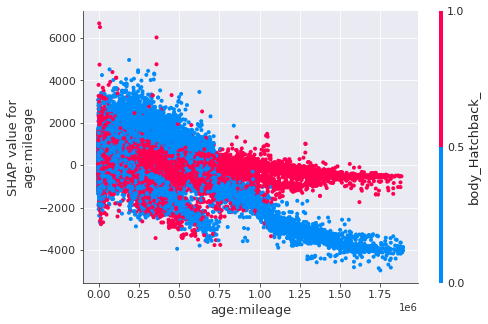

In [ ]:
shap.dependence_plot('age:mileage', shap_values, X_test, interaction_index='body_Hatchback_')

An interesting observation is seen in the case of the interaction between age:mileage and Hatchbacks. Most of the non Hatchback cars with lower age:mileage values have a stronger impact on the model.

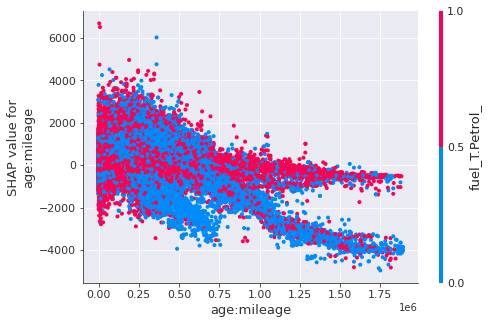

In [ ]:
shap.dependence_plot('age:mileage', shap_values, X_test, interaction_index='fuel_T.Petrol_')

However, when considering the cars running on Petrol or not, we can infer that both cars running on and without petrol has a strong interaction against age:mileage.

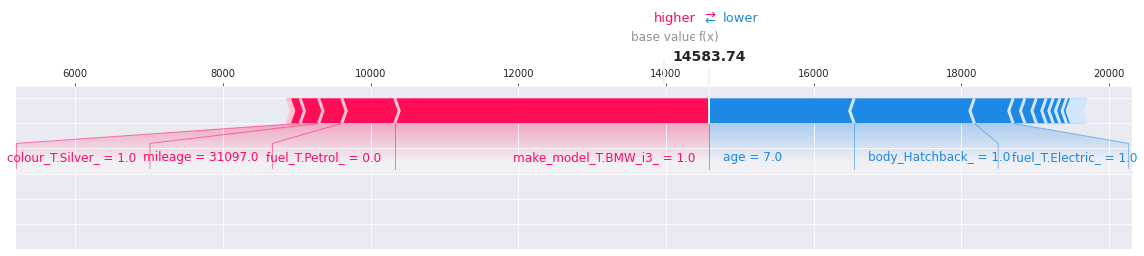

In [ ]:
# generating the force plot to get a local explanatiion
row_idx = 1

shap.force_plot(
    explainer.expected_value, 
    shap_values[row_idx], 
    X_test.iloc[row_idx],
    matplotlib=True
)

The force plot tells us that the model output is 14583.74 and cars with silver colour, mileage = 31K+ that do not use petrol and are i3 Series BMWs impact the model predictions more as oposed to Hatchback cars running on Electricity with an age of 7 having the least impact on the model output.

Explain these plots

### XGBoost
XGBoost is an implementation of gradient boosted trees algorithm. Gradient boosted tree is a supervised algorithm which attempts to accurately predict a target at this case price of the cars by adding the estimators (trees)  of a set of simpler or weaker models. These weak learners are regression trees which map an input data point to one of its leaves that contains a continuous score. XGBoost minimises an objective function that combines a loss function. Which is the difference between predicted car prices and the actual prices and a penalty term for adding model complexity also known as regression tree functions. The training of these algorithms goes in an iterative process adding new trees that predict the residuals or errors of prior trees that are then combined with previous trees to make the final price predictions. 40 estimators are optimal with an objective function of "reg:squarederror" and the learning rate of 0.8 which is the shrinkage size of the feature weights after each boosting of the trees.

In [ ]:
# creating the object of XGBRegressor

xg_reg = XGBRegressor(n_estimators=40, 
                      objective='reg:squarederror', 
                      learning_rate=0.8, 
                      random_state=42, 
                      n_jobs=-1)

# fitting the model
xg_reg.fit(X_train_sc, y_train)

# making predictions
xg_pred = xg_reg.predict(X_test_sc)

In [ ]:
# evaluating the model and storing the results
xg_mae = np.round(mean_absolute_error(y_test, xg_pred),2)
xg_rmse = np.round(mean_squared_error(y_test, xg_pred, squared=False),2)
xg_r2 = np.round(r2_score(y_test, xg_pred),2)

# displaying the results
print("MAE of XGBoost Regressor on the Test Set: ", xg_mae)
print("RMSE of XGBoost on the Test Set: ", xg_rmse)
print("R2 score of XGBoost Regressor is: ",xg_r2)

# storing the results
model_names.append("XGBoost Regressor")
mae_test.append(xg_mae) 
rmse_test.append(xg_rmse)
r2_scores_test.append(xg_r2)

MAE of XGBoost Regressor on the Test Set:  2508.23
RMSE of XGBoost on the Test Set:  3451.13
R2 score of XGBoost Regressor is:  0.82


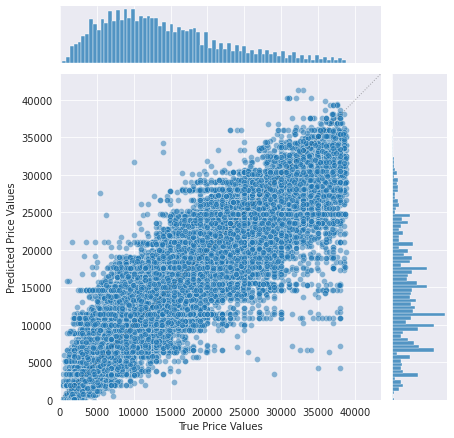

In [ ]:
# true vs predicted plot of the model performance
true_pred_plot(xg_pred)

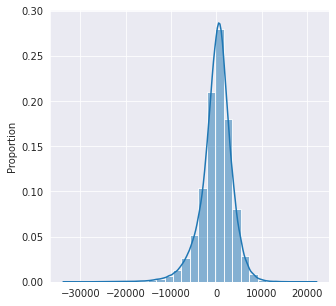

In [ ]:
# residual plot of the model
resd_plot(xg_pred)

In the case of XGBoost Regressor the values of MAE, and RMSE are over 2500 and 3400 and the R2-Score is just 0.82. This indicates that for this dataset this model performed poorly compared to Random Forest which can be observed by the higher number of distortion of points from the regression line in the true vs predicted plot and higher negative residuals in the residual plot.

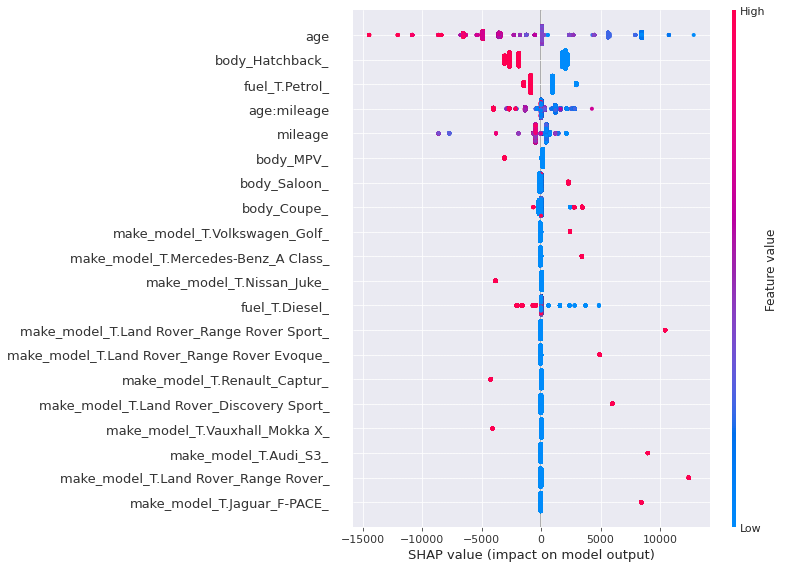

In [ ]:
# generating the global feature importance with shap values
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_test_sc, tree_limit=10, approximate=True, check_additivity=False)
shap.summary_plot(shap_values, X_test)

The summary plot of the XGBoost regressor also tells us that `age`, `body_Hatchback_`, `age:mileage` and `fuel_T.Petrol_` are the 4 most important features of this model.


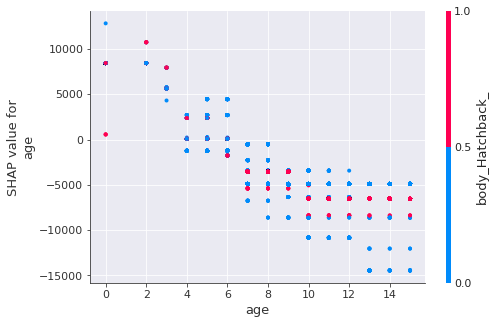

In [ ]:
# dependence plots of the four most important features
shap.dependence_plot('age',shap_values,X_test,interaction_index='body_Hatchback_')

Similar to the outputs of Random Forest, we can observe that newer cars that are not hatchbacks seem to have a stronger impact on the model outputs.

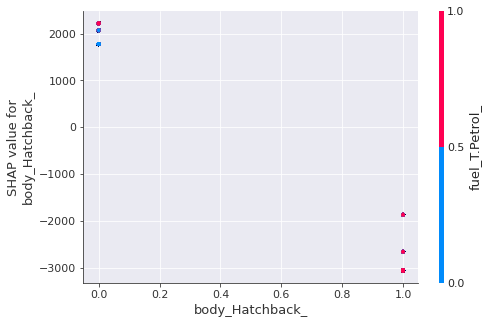

In [ ]:
shap.dependence_plot('body_Hatchback_',shap_values,X_test,interaction_index='fuel_T.Petrol_')

We see almost an identical output of the interactions between Hatchbaks and cars running on Petrols when compared to the plot generated for Random Forest.

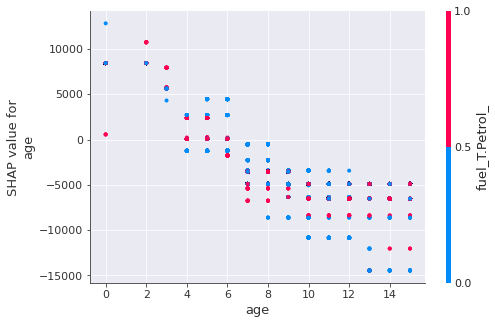

In [ ]:
shap.dependence_plot('age',shap_values,X_test,interaction_index='fuel_T.Petrol_')

Cars not running on Petrol and between the age range of 0 to 6 has the most impact, however, those between 8 to 14 have very negative SHAP values showing that older cars have a negative impact on the prices.

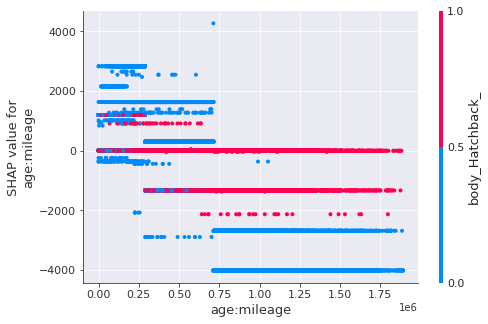

In [ ]:
shap.dependence_plot('age:mileage',shap_values,X_test,interaction_index='body_Hatchback_')

Most of the Hatchback cars have weak impacts on the prices.

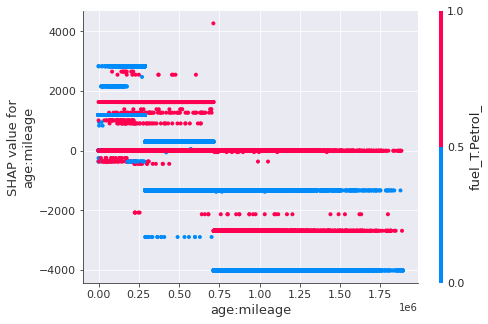

In [ ]:
shap.dependence_plot('age:mileage',shap_values,X_test,interaction_index='fuel_T.Petrol_')

However, most of the cars running on Petrol have the strongest impact on the prices.

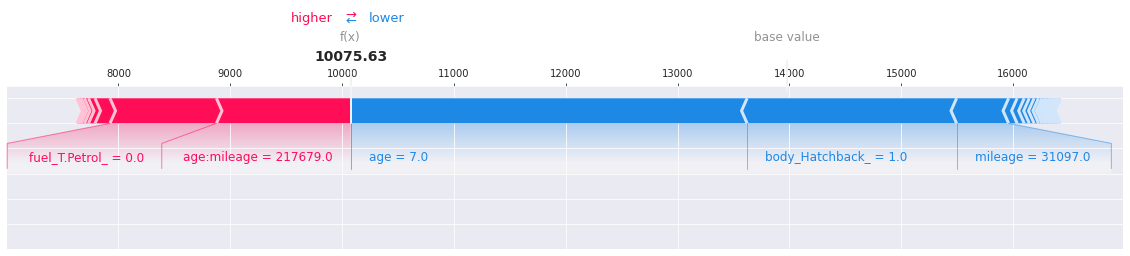

In [ ]:
# a local explanation of the feature importance with a force plot
row_idx = 1

shap.force_plot(
    explainer.expected_value, 
    shap_values[row_idx], 
    X_test.iloc[row_idx],
    matplotlib=True
)

From a local perspective of the XGBoost Regressors interpretability, we can see that the model output is 100075.63. But we can see some similarities in the behaviour of the XGBoost model compared to the Random Forrest model. Here cars not running on Petrol has a higher impact on the output and cars with age 7 and having a body type of Hatchback has the least, however, in the case of XGBoost, we see that mileage = 31K+ has a lower impact on the model's performance.

### Linear Support Vector Regressor
Linear Support Vector Regressor is an algorithm that solves regression problems. This algorithm applies the linear kernel method rather than radial bias or polynomial kernels and works well on large datasets. There are two loss functions epsilon_insensitive’, ‘and squared_epsilon_insensitive’ the first one is the default and in this project worked best. No hyperparameter tweaking was necessary to build and train this model for this project.

In [ ]:
# creating the LinearSVR model
svr = LinearSVR(random_state=42)

# fitting the model
svr.fit(X_train_sc, y_train)

# making predictions
lr_pred = svr.predict(X_test_sc) 

In [ ]:
# generating evaluation results
svr_mae = np.round(mean_absolute_error(y_test, lr_pred),2)
svr_rmse = np.round(mean_squared_error(y_test, lr_pred, squared=False),2)
svr_r2 = np.round(r2_score(y_test, lr_pred),2)

# displaying the results
print("MAE of Linear Support Vector Regressor on the Test Set: ", svr_mae)
print("RMSE of Linear Support Vector Regressor on the Test Set: ", svr_rmse)
print("R2 score of Linear Support Vector Regressor is: ",svr_r2)

# storing the results
model_names.append("Linear Support Vector Regressor")
mae_test.append(svr_mae) 
rmse_test.append(svr_rmse)
r2_scores_test.append(svr_r2)

MAE of Linear Support Vector Regressor on the Test Set:  2095.25
RMSE of Linear Support Vector Regressor on the Test Set:  3065.83
R2 score of Linear Support Vector Regressor is:  0.86


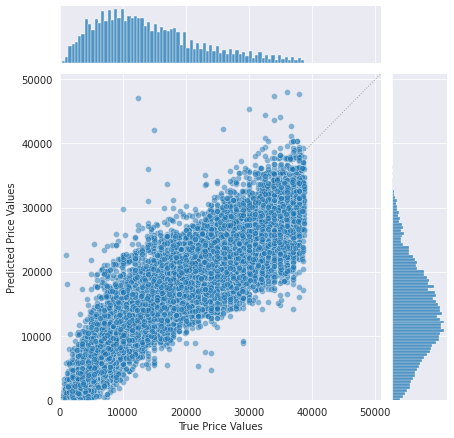

In [ ]:
# generating the true vs predicted plot
true_pred_plot(lr_pred)

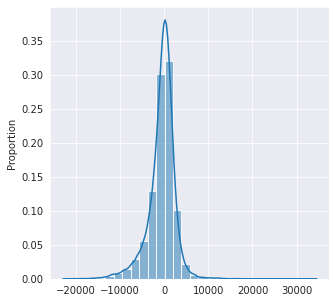

In [ ]:
# generating the residual plot
resd_plot(lr_pred)

The Linear SVR has an R2-Score of 0.86, MAE and RMSE scores of 2000 and 3000. In comparison to the XGBoost, this model has performed better, but we can see a higher number of negative residuals from the residual plot of the predictions made by this model on the test data.

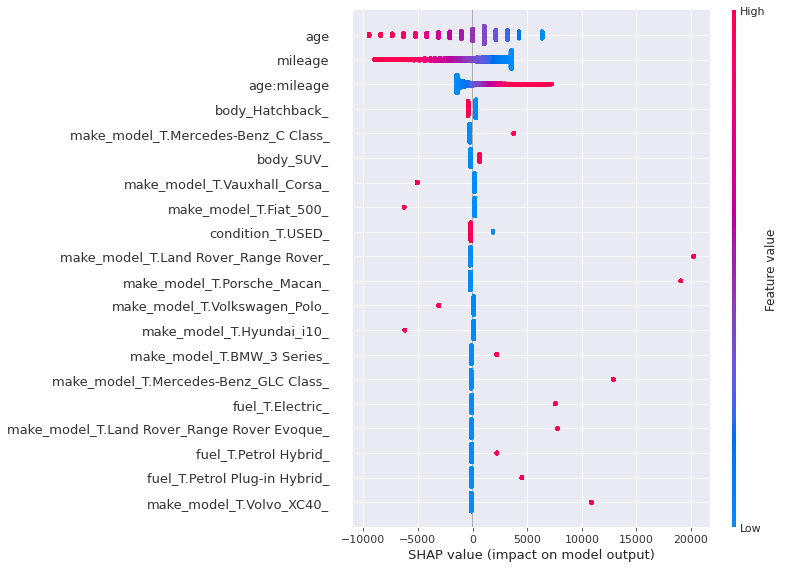

In [ ]:
# a global explanation of the most important features with SHAP summary plot
explainer = shap.LinearExplainer(svr,X_test_sc)
shap_values = explainer.shap_values(X_test_sc)
shap.summary_plot(shap_values, X_test)

The summary plot of the Linear Support Vector regressor predictions shows that the outputs generated by this model are most influenced by `age`, `mileage`, `age:mileage` and `body_type_Hatchback`.

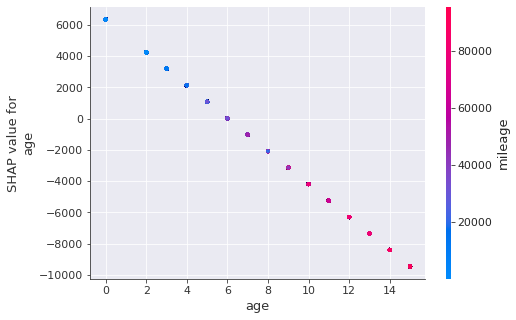

In [ ]:
# Drawing dependence plots of the important features
shap.dependence_plot('age',shap_values,X_test,interaction_index='mileage')

The dependence plot of age against the interaction of mileage shows that cars with less age have a higher shap value, from this we can understand that these cars have the strongest impact on the predictions made by the Linear SVR model.

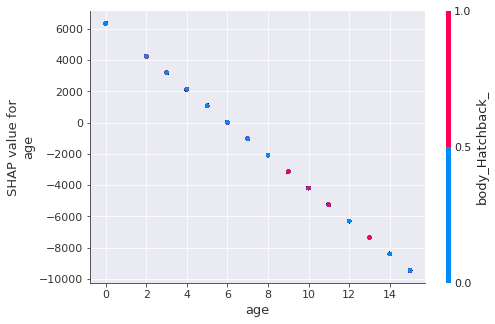

In [ ]:
shap.dependence_plot('age',shap_values,X_test,interaction_index='body_Hatchback_')

Looking at the Dependence Plot of age with the interaction of body_Hatchback_ we can understand that newer cars that do not have this body type have a stronger impact on the model performance.

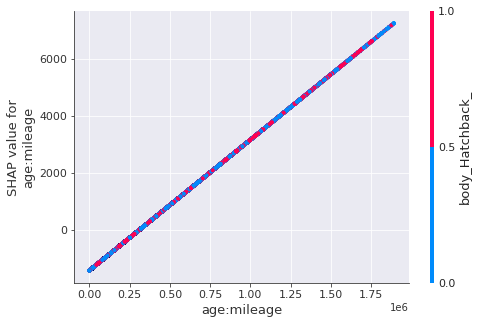

In [ ]:
shap.dependence_plot('age:mileage',shap_values,X_test,interaction_index='body_Hatchback_')

The dependence plot of age:mileage with the interaction of body_Hatchback tells us that age:mileage has a strong impact on the model particularly with cars which do not have this body type.

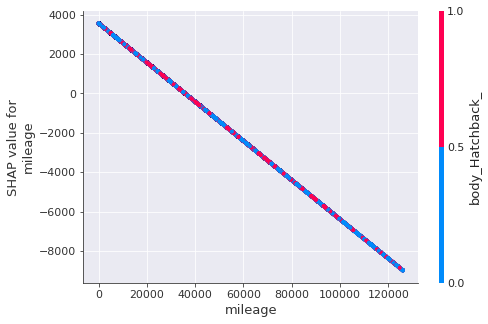

In [ ]:
shap.dependence_plot('mileage',shap_values,X_test,interaction_index='body_Hatchback_')

The dependence plot of mileage created with the interaction index of body_Hatchback_ again tells us that newer cars without this body type have a stronger impact on the model performance as we can see from the y-axis that the SHAP values corresponding to lower mileage values are higher.

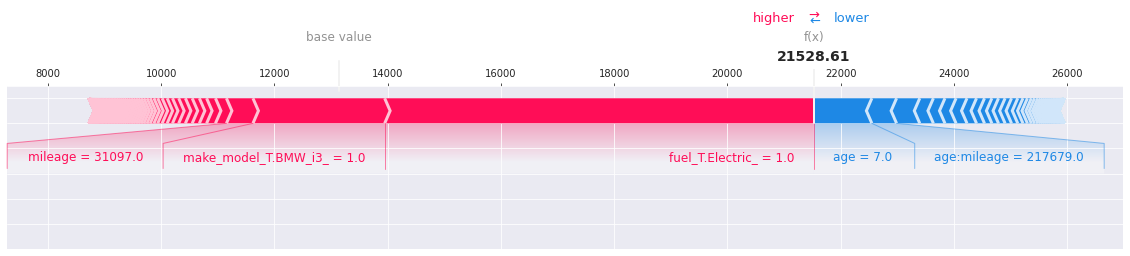

In [ ]:
# a local explanation with SHAP force plot
row_idx = 1

shap.force_plot(
    explainer.expected_value, 
    shap_values[row_idx], 
    X_test.iloc[row_idx],
    matplotlib=True
)

From a local perspective of the XGBoost Regressors interpretability, we can see that the model output is 100075.63. But we can see some similarities in the behaviour of the XGBoost model compared to the Random Forrest model. Here cars not running on Petrol has a higher impact on the output and cars with age 7 and having a body type of Hatchback has the least, however, in the case of XGBoost, we see that mileage = 31K+ has a lower impact on the model's performance but Electric Cars have a higher impact on the output. One interesting thing is noticed from all the force plots is that 7-year-old cars have the lower impacts on the three ML models I have trained.

### Bagging Regressor
For the final step of building models, I have built and trained a Bagging Regressor. This is an ensemble meta-estimator that fits base regressors in this case (RF, XGB and SVR) each on random subsets of the original dataset and then aggregate their predictions (either by voting or by averaging) to form a final prediction. Among the hyperparameters, max_samples and max_features control the size of the subsets (in terms of samples and features), while bootstrapping and bootstrap_features control whether samples and features are drawn with or without replacement. I have set max_samples to 1.0 and max_features as it is and set n_estimators to 3 as I have trained three estimators, there is another hyperparameter which is the base_estimator and by default, it runs a decision tree if set to default. I have created a function to carry out all this process for convenience and returned the predictions made by the model on the test set after fitting on the training set. Then I stored all the predicted values in the predictions variable using np.column_stack to store all the predictions of the estimators into a column and then took the average of these to get the final predictions (y_pred). Then used y_pred values to display the MAE, RMSE and R2-Scores and display the true vs predicted and residual plots of the Bagging Regressor model. 

In [ ]:
# I am creating this function to take in the base estimators (the trained models) to build a bagging model of regressors
# this function will return the predictions made by the bagged regressor which I will then use to analyse this models performance

def bagging_predictions(estimator):
  bager = BaggingRegressor(n_estimators = 3, 
                            max_samples = 1.0,
                            bootstrap=True, # samples are drawn with replacement
                            n_jobs = -1,
                            random_state = 42).fit(X_train_sc, y_train)

  br_y_pred = bager.predict(X_test_sc)

  return br_y_pred

In [ ]:
# since we are getting the predicted values from each time the function is run so I am sotring them in a variable called predictions and stacking
# them in a numpy column
predictions = np.column_stack((bagging_predictions(rf),
                              bagging_predictions(xg_reg),
                              bagging_predictions(svr)))

In [ ]:
# displaying the predictions stored in the stacked column
predictions

array([[25566.68518519, 25566.68518519, 25566.68518519],
       [14261.66666667, 14261.66666667, 14261.66666667],
       [ 4698.33333333,  4698.33333333,  4698.33333333],
       ...,
       [34239.77777778, 34239.77777778, 34239.77777778],
       [ 5083.33333333,  5083.33333333,  5083.33333333],
       [ 6458.33333333,  6458.33333333,  6458.33333333]])

In [ ]:
# here I am getting the average of the values stored in each of the columns so the axis is set to 1.
y_pred = np.mean(predictions, axis=1)
y_pred

array([25566.68518519, 14261.66666667,  4698.33333333, ...,
       34239.77777778,  5083.33333333,  6458.33333333])

In [ ]:
# following lines of code calculates the MAE, RMSE and R2-Scores of the bagged regressor
bag_mae = np.round(mean_absolute_error(y_test, y_pred),2)
bag_rmse = np.round(mean_squared_error(y_test, y_pred, squared=False),2)
bag_r2 = np.round(r2_score(y_test, y_pred),2)

# Displaying the results
print("MAE of Bagged Regressor on the Test Set: " ,bag_mae)
print("RMSE of Bagged Regressor on the Test Set: " ,bag_rmse)
print("R2 score of Bagged Regressor is: " ,bag_r2)
 
# Appending the results into the lists
model_names.append("Bagged Regressor")
mae_test.append(bag_mae) 
rmse_test.append(bag_rmse)
r2_scores_test.append(bag_r2)

MAE of Bagged Regressor on the Test Set:  1631.06
RMSE of Bagged Regressor on the Test Set:  2456.36
R2 score of Bagged Regressor is:  0.91


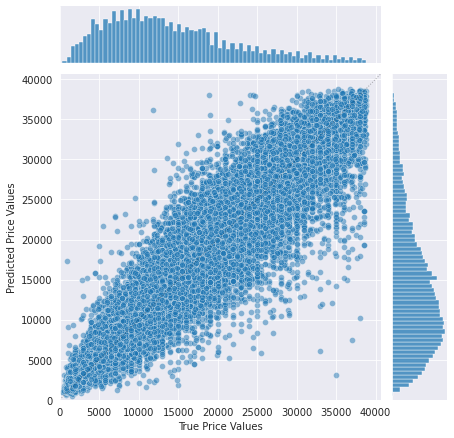

In [ ]:
# generating true vs predicted plots
true_pred_plot(y_pred)

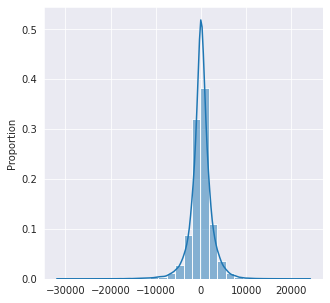

In [ ]:
# generating the residual plot
resd_plot(y_pred)

The MAE and RMSE scores for the Bagged Regressor are decent and the R2-Score is 0.91 which indicates that this regression model has fitted the data well and the outputs of the True Vs Predicted and residual plots prove it.

##Results Discussion
###Discussion of Results Obtained From the Performance Matrices

In [ ]:
# Creating a dictionary to store the results 
d = {'Models':model_names, 'MAE':mae_test, 'RMSE':rmse_test, 'R2-Score':r2_scores_test}

# using that dictionary to create a dataframe of the results to display as a table
df = pd.DataFrame(d)
df

,Models,MAE,RMSE,R2-Score
0,Random Forest Regressor,1517.02,2281.19,0.92
1,XGBoost Regressor,2508.23,3451.13,0.82
2,Linear Support Vector Regressor,2095.25,3065.83,0.86
3,Bagged Regressor,1631.06,2456.36,0.91


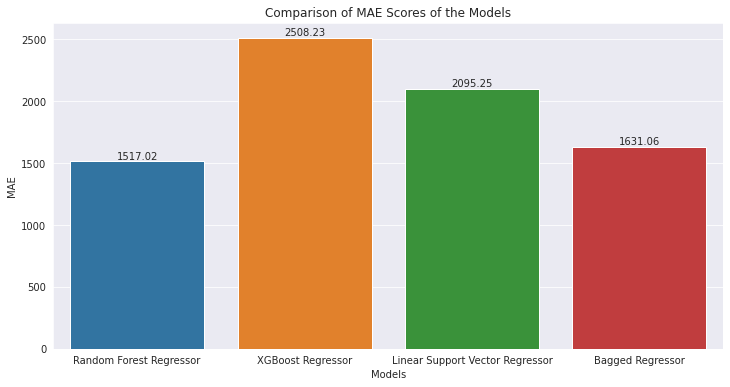

In [ ]:
# Displaying the models MAE values as a bar plot

# create vertical barplot showing the results
plt.figure(figsize=(12,6))
plt.title("Comparison of MAE Scores of the Models")
p = sns.barplot(x="Models", y="MAE", data=df, ci=None)

#show values on barplot
show_values(p)

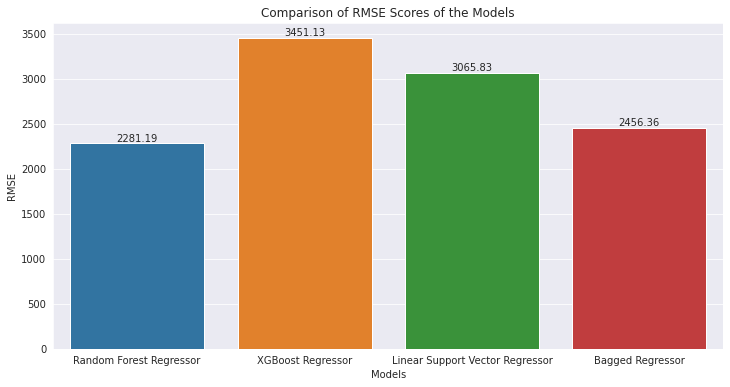

In [ ]:
# displaying the models RMSE values as a bar plot 

# create vertical barplot showing the results
plt.figure(figsize=(12,6))
plt.title("Comparison of RMSE Scores of the Models")
p = sns.barplot(x="Models", y="RMSE", data=df, ci=None)

#show values on barplot
show_values(p)

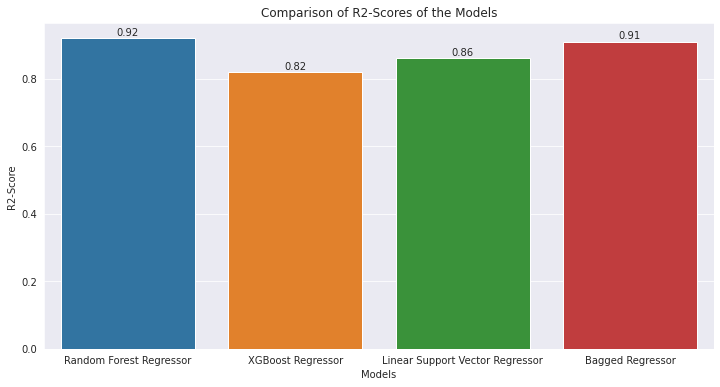

In [ ]:
# displaying the models R2-Scores as a bar plot

# create vertical barplot showing the results
plt.figure(figsize=(12,6))
plt.title("Comparison of R2-Scores of the Models")
p = sns.barplot(x="Models", y="R2-Score", data=df, ci=None)

#show values on barplot
show_values(p)

In this section, I have produced a table to display the obtained scores of the evaluation metrics used for model prediction analysis. Then I have provided three plots to show the comparison of the MAE, RMSE and R2-Scores of the models. From the obtained results we can see that Overall in terms of the scores obtained Random Forest Regressor was the ideal model. In terms of MAE score, it obtained a score of 1517.02 compared to 1631.06 of the Bagged Regressor whereas the values of XGBoost and Linear SVR are 2508.23 and 2095.25. The RMSE score of the Random Forrest Regressor is 2281.19 compared to 2456.36 achieved by the Bagged Regressor and this figure is 3000+ for the other models. In terms of the R2-Scores, Random Forrest and the Bagging Regressor produced 0.92 and 0.91 but Linear SVR's score is 0.82 and XGBoost is 0.86.

###Summary of Model Interpretability
In terms of global explanations, from the summary plots of all the models, we can understand that `age` and `body_Hatchback` are the two most important features of all the models. The dependence plots further showed that age mileage also has a profound impact on car prices. As both of these numeric features have a negative correlation with `price`. This again further proves the hypothesis that new cars have a higher price range. Among the categorical variables, the cars which are not hatchbacks and do not run on petrol have a stronger impact on the model outputs. From the local explanations, it can be concluded that 7-year-old cars have the lower impacts on the model outputs whereas, the BMW i3 Series and cars having mileage values of more than 31K have a higher impact on the predictions.


###What Auto Trader can Learn From this Project
The ideal model among the trained models is Random Forest Regressor and this is evidenced by the results obtained from the evaluation Matrices. Compared to models like XGBoost, Linear SVR and Bagged Regressor we can say that Random Forest has another edge over them, the fact that this Algorithm works by building on several decision trees, means that we can easily explain the model to stakeholders of non-technical backgrounds. This further means that Auto Traders can consider deploying this model for production. The most important features found are age, mileage, age:mileage and body_Hatchback. From the SHAP explanations, we saw that newer cars had the most impact on the model outcomes with cars having a body type other than Hatchback. From this output, Auto Traders should consider providing more ads for new cars rather than second-hand ones which are of a different body type than Hatchback.


##Conclusion
In this project, the Auto Trader dataset has been explored to build and train different types of Advanced ML models namely, Random Forrest Regressor, XGBoost Regressor and Linear Support Vector Regressor. Then the three were ensembled to build and train a Bagged Regressor model. Before building the models, the dataset was explored to engineer and select new and useful features, and then the new dataset was prepared for the training of the models, after training the models were evaluated using a number of evaluation methods and explained by Global and Local Explanation Plots using SHAP. The results show that Random Forest was the best model and it produced an RMSE value of 2281.19 and R2-Score of 0.92. From the model interpretability plots, it is found that age and mileage are the most important features that had the highest impact on the model's performance.

###Future Work
Access to a high-end computer and time constraints were the major limitations of this project, to get a better idea of the performances of the models, I would like to perform extensive hyperparameter tuning via GridSearch and perform cross-validation to validate the model results. Also, the dataset used mostly contains categorical features, so as a future extension of this work it would be ideal to merge another similar dataset to engineer further features such as miles per gallon, depreciation price and so on and then see how the models would treat these features. I would also like to perform Principal Component Analysis to reduce the dimensionality of the dataset to generate new features and re-train the models on the new data.